# Assignment 2 Notebook Overview

> Note 1: for answers with Python, display both codes and results clearly. You may explain 
answers with either comments, markdowns or print() function.

> Note 2: for answers with manual calculation, please display all calculation steps clearly. 

> Note 3: round all numerical answers to 2 decimal places.    

## 0. Environment Setup

Load helper libraries, style the plotting backend, and pull the shared `smoking.csv` dataset for reuse across later sections.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score  

## 1. Question 1 - Logistic Regression Walkthrough

Suppose we collect data for a group of students in a course with variables 𝑋1 = ℎ𝑜𝑢𝑟𝑠 𝑠𝑡𝑢𝑑𝑖𝑒𝑑, 𝑋2 = 𝐶𝑢𝑚𝑢𝑙𝑎𝑡𝑖𝑣𝑒  𝑃𝐴, and 𝑦 = 1 if the student receives an A in this course and 𝑦 = 0 otherwise. We trained a logistic regression model on this dataset to predict whether a student can receive A with features 𝑋1 and 𝑋2, the estimated parameters are  𝑤0 = −7, 𝑤1 = 0.05, 𝑤2 = 1.  Answer the following questions with either Python or manual calculation.  

In [2]:
w0 = -7.0   # intercept term
w1 = 0.05   # coefficient for X1 = hours studied
w2 = 1.0    # coefficient for X2 = cumulative GPA

### (a) What is the probability that a student who studies for 40 hours and has a cumulative GPA of 3.5 gets an A in the class?   

In [3]:
hours_example = 40        # X1 from the problem statement
gpa_example = 3.5         # X2 from the problem statement

# Compute the predicted score using the linear model
predicted_score = w0 + w1 * hours_example + w2 * gpa_example

# Compute the predicted probability using the logistic function (sigmoid)
predicted_probability = 1 / (1 + np.exp(-predicted_score))

print("Part (a)")
print(f"  The predicted probability that a student who studies for {hours_example} hours and has a cumulative GPA of {gpa_example} gets an A in the class is approximately {predicted_probability:.2f}")

Part (a)
  The predicted probability that a student who studies for 40 hours and has a cumulative GPA of 3.5 gets an A in the class is approximately 0.18


### (b) How many hours would the student in step (a) need to study to have a 50% chance of getting an A in the class? 

In [4]:
# Solve w0 + w1 * hours + w2 * GPA = 0 for hours when GPA stays at 3.5
# (since logit = 0 corresponds to P = 0.5).
target_probability = 0.50
target_logit = np.log(target_probability / (1 - target_probability))  # equals 0.0
hours_for_half = (-w0 - w2 * gpa_example) / w1

print("Part (b)")
print(f"  Hours needed for 50% chance (same GPA): {hours_for_half:.2f}")

Part (b)
  Hours needed for 50% chance (same GPA): 70.00


### (c) What is the odds ratio and log-odds for the student in (a)? And what does the odds ratio mean?   

In [5]:
# Odds (p / (1 - p)) equal exp(log-odds) for logistic regression outputs.
odds_a = np.exp(predicted_score)

print("Part (c)")
print(f"  Odds (p/(1-p)) for these inputs: {odds_a:.2f}")
print(f"  Log-odds: {predicted_score:.2f}")
print(f"  Interpretation: For every 1 student predicted to earn an A, ~{(1 / odds_a):.2f} students are predicted not to (given these inputs).")

Part (c)
  Odds (p/(1-p)) for these inputs: 0.22
  Log-odds: -1.50
  Interpretation: For every 1 student predicted to earn an A, ~4.48 students are predicted not to (given these inputs).


### (d) Visualize the model (the linear hyperplane) with a simple line plot where 𝑋1 is on the 𝑥-axis and 𝑋2 on the 𝑦-axis. Also indicate the region for A grade (positive, 𝑦 = 1) and region for non-A grade (negative) in the figure.  (Hint: you can draw the plot manually or with the help of any software.)

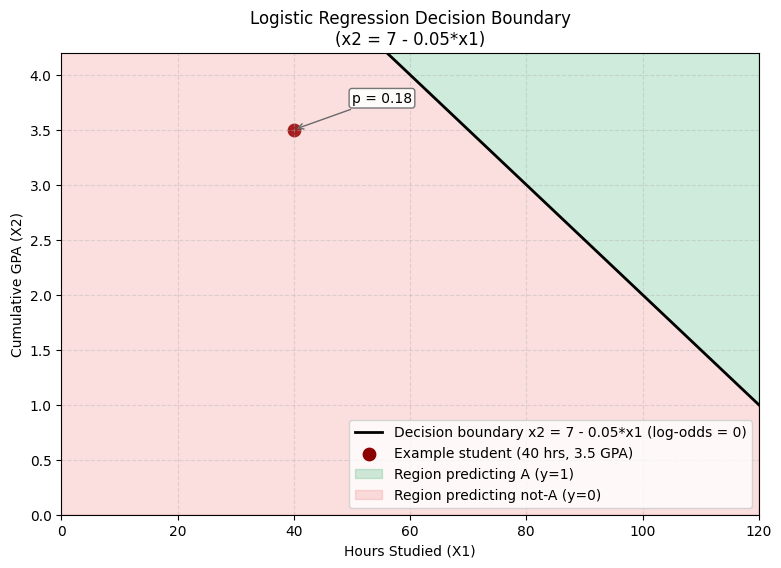

In [6]:
# Plot the linear decision boundary w0 + w1*x1 + w2*x2 = 0.
# Rearranged: x2 = (-w0 - w1*x1) / w2, which simplifies to x2 = 7 - 0.05*x1.
x1_vals = np.linspace(0, 120, 200)                      # hours studied range
decision_boundary = (-w0 - w1 * x1_vals) / w2           # GPA threshold per hour value
boundary_label = "Decision boundary x2 = 7 - 0.05*x1 (log-odds = 0)"

plt.figure(figsize=(9, 6))
plt.plot(x1_vals, decision_boundary, color="black", lw=2, label=boundary_label)
plt.scatter(
    hours_example,
    gpa_example,
    color="darkred",
    s=80,
    label="Example student (40 hrs, 3.5 GPA)",
)

# Shade the positive (A grade) region: GPA >= boundary (log-odds > 0).
plt.fill_between(
    x1_vals,
    decision_boundary,
    4.2,                         # cap shading near the top of the GPA axis
    where=decision_boundary <= 4.2,
    color="mediumseagreen",
    alpha=0.25,
    label="Region predicting A (y=1)",
)

# Shade the negative region: GPA < boundary (log-odds < 0).
plt.fill_between(
    x1_vals,
    0,
    decision_boundary,
    color="lightcoral",
    alpha=0.25,
    label="Region predicting not-A (y=0)",
)

plt.annotate(
    f"p = {predicted_probability:.2f}",
    xy=(hours_example, gpa_example),
    xytext=(hours_example + 10, gpa_example + 0.25),
    arrowprops=dict(arrowstyle="->", color="dimgray"),
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="dimgray", alpha=0.9),
)

plt.title("Logistic Regression Decision Boundary\n(x2 = 7 - 0.05*x1)")
plt.xlabel("Hours Studied (X1)")
plt.ylabel("Cumulative GPA (X2)")
plt.ylim(0, 4.2)
plt.xlim(0, 120)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="lower right")
plt.show()

## Question 2. Odds-ratio and Probability [20 points] 

> Please answer the following questions either Python or manual calculation. 

### (a) Suppose that an individual has a 20% chance of defaulting on her credit card (positive, 𝑦 = 1) payment. What is the odds-ratio of defaulting?   

In [7]:
# Part (a): convert the known probability into odds (single-event perspective).
prob_default = 0.20
odds_default = prob_default / (1 - prob_default)

print(f"Odds (p/(1-p)) for defaulting with prob_default=0.20 are {odds_default:.2f}")
print(f"Interpretation: For every 1 payment predicted to default there are {(1 / odds_default):.2f} payments predicted not to default.")

Odds (p/(1-p)) for defaulting with prob_default=0.20 are 0.25
Interpretation: For every 1 payment predicted to default there are 4.00 payments predicted not to default.


### (b) Suppose the odds-ratio of defaulting on credit card payment for a man is 0.4, what is the probability this person will default on his credit card payment? 

In [8]:
# Part (b): convert the known probability into odds (single-event perspective).
odds_input = 0.40
prob_from_odds = odds_input / (1 + odds_input)

print(f"(b) Probability implied by odds 0.40: {prob_from_odds:.2f} | probability of paying on time: {1 - prob_from_odds:.2f}")

(b) Probability implied by odds 0.40: 0.29 | probability of paying on time: 0.71


## Question 3. Support Vector Machine [20 points]

> A support vector classifier was fitted to a small data set with 12 instances, each represented by a colored number in the following figure. Their colors indicate their classes (blue represents positive, red represents negative). The hyperplane (solid line) and 
the two margins (dashed lines) are plotted as well.  Please answer the following questions with your own words.  

### (a) List the number of instances that are support vectors in this model.  

**Definition.** In a linear SVM with decision function
$$ f(x) = w^\top x + b, $$
a point $(x_i, y_i)$ is a **support vector** if
$$ y_i \, f(x_i) \le 1. $$

**Plain-English rule:**
- Points **on** either margin line or **between** the margins are support vectors.
- Points that are **misclassified** ($ y_i f(x_i) < 0 $) are also support vectors.

**For the given plot:** the support vectors are **1, 2, 7, 8, 9, 11, 12**.

### (b) Suppose instance 4 (i.e., the red number 4 in the figure) moves closer to its margin. Will that affect the position of the hyperplane?  

**Key fact.** In a linear SVM, the decision boundary depends **only** on the support vectors.

Let the decision function be
$$ f(x) = w^\top x + b. $$

**Implication for point 4:**
- If point 4 stays **outside the margins**, i.e.
  $$ y_4\,f(x_4) > 1, $$
  moving it around **does not change** the hyperplane.
- The boundary **changes** only if point 4 becomes a support vector or is misclassified:
  - On/inside a margin when
    $$ y_4\,f(x_4) \le 1, $$
  - Misclassified when
    $$ y_4\,f(x_4) < 0. $$

**Answer:** As drawn, point 4 is not a support vector, so small movements of point 4 will **not** change the decision boundary. It will change only once point 4 hits a margin or crosses it.


### (c) List the number of instances that will bring hinge loss to but NOT be misclassified.

**Definitions.** With decision function
$$ f(x) = w^\top x + b, $$
the hinge loss for a labeled point $(x_i, y_i)$ is
$$ \ell_{\text{hinge}}(x_i, y_i) = \max\!\big(0,\; 1 - y_i f(x_i)\big). $$

- **Misclassified** iff \( y_i f(x_i) < 0 \).
- **Hinge loss > 0** iff \( y_i f(x_i) < 1 \).

**Therefore,** points that **incur hinge loss but are not misclassified** satisfy
$$ 0 \le y_i f(x_i) < 1, $$
i.e., they lie **inside the margin on the correct side** of the boundary.

**For the given plot:** the points are **1, 2, 7, 8, 9**  
so the **count is 5**.


### (d) List the number of instances that would be misclassified. 

**Decision function**
$$ f(x) = w^\top x + b. $$

**Misclassification criterion**
A labeled point $(x_i, y_i)$ is **misclassified** iff
$$ y_i\,f(x_i) < 0. $$

Equivalently: the predicted sign $\operatorname{sign}(f(x_i))$ disagrees with the label $y_i$.

**For the given plot:** the misclassified points are **11** and **12**,  
so the **count is 2**.


## Question 4. Logistic Regression [30 points]

> We’d like to use the dataset smoking.csv to build a logistic regression model to predict whether a person smoke or not (𝒔𝒎𝒐𝒌𝒆𝒓) with three features:  𝒔𝒎𝒌𝒃𝒂𝒏 (i.e., whether smoking was banned in this person’s country), 𝒇𝒆𝒎𝒂𝒍𝒆 (i.e., whether the person is female or not) and 𝒂𝒈𝒆 (i.e., age of this person).  Please answer the following questions with Python.

## First Look

In [9]:
from pathlib import Path

# Load the assignment dataset (ships with the notebook repository)
# ------------------------------------------------------------------
DATA_PATH = Path("smoking.csv")          # update if you store the CSV elsewhere
smoking_df = pd.read_csv(DATA_PATH)      # load the CSV into a pandas DataFrame

# ------------------------------------------------------------------
# Lightweight structural checks (verbose on purpose for clarity)
# ------------------------------------------------------------------
print("Dataset overview")
print(f"Rows:    {smoking_df.shape[0]}")
print(f"Columns: {smoking_df.shape[1]}")
print("Column names in order:")
display(smoking_df.info())  # includes non-null counts and types
print("Summary stats for numeric + categorical")
display(smoking_df.describe().T)  # transpose for better readability
print("First 5 rows")
display(smoking_df.head())  # first 5 rows

Dataset overview
Rows:    10000
Columns: 10
Column names in order:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   smoker    10000 non-null  int64
 1   smkban    10000 non-null  int64
 2   age       10000 non-null  int64
 3   hsdrop    10000 non-null  int64
 4   hsgrad    10000 non-null  int64
 5   colsome   10000 non-null  int64
 6   colgrad   10000 non-null  int64
 7   black     10000 non-null  int64
 8   hispanic  10000 non-null  int64
 9   female    10000 non-null  int64
dtypes: int64(10)
memory usage: 781.4 KB


None

Summary stats for numeric + categorical


,count,mean,std,min,25%,50%,75%,max
smoker,10000.0,0.2423,0.428496,0.0,0.0,0.0,0.0,1.0
smkban,10000.0,0.5466,0.497849,0.0,0.0,1.0,1.0,1.0
age,10000.0,37.6008,12.997166,14.0,28.0,37.0,46.0,86.0
hsdrop,10000.0,0.0912,0.287908,0.0,0.0,0.0,0.0,1.0
hsgrad,10000.0,0.3266,0.468993,0.0,0.0,0.0,1.0,1.0
colsome,10000.0,0.2802,0.449119,0.0,0.0,0.0,1.0,1.0
colgrad,10000.0,0.1972,0.397905,0.0,0.0,0.0,0.0,1.0
black,10000.0,0.0769,0.266446,0.0,0.0,0.0,0.0,1.0
hispanic,10000.0,0.1134,0.317097,0.0,0.0,0.0,0.0,1.0
female,10000.0,0.5268,0.499306,0.0,0.0,1.0,1.0,1.0


First 5 rows


,smoker,smkban,age,hsdrop,hsgrad,colsome,colgrad,black,hispanic,female
0,1,0,49,0,1,0,0,0,0,0
1,1,0,52,0,0,1,0,0,0,0
2,0,0,15,0,0,1,0,0,0,1
3,1,0,37,0,1,0,0,0,0,0
4,0,1,24,0,0,1,0,0,0,1


### (a) How many instances are there? How many smokers (i.e., s𝑚𝑜𝑘𝑒𝑟 = 1) and non-smokers (i.e., 𝑠𝑚𝑜𝑘𝑒𝑟 = 0) respectively? 

In [10]:
# Counts
counts = smoking_df['smoker'].value_counts().reindex([0, 1], fill_value=0)
print(counts)

print()

# Percentages (calculated separately, no .get)
total = int(counts.sum())
non_smokers = int(counts[0])
smokers = int(counts[1])

pct_non = (non_smokers / total * 100)
pct_smk = (smokers / total * 100)

print("Percentages:")
print(f"0 (non-smokers): {pct_non:.2f}%")
print(f"1 (smokers):     {pct_smk:.2f}%")

print()

# Answers with counts + percentages
print(f"ANSWER a) There are {total} instances")
print(f"ANSWER a) of which {smokers} are smokers ({pct_smk:.2f}%) and {non_smokers} are non-smokers ({pct_non:.2f}%)")

# Baseline accuracy if we always predict 0 (majority = non-smoker)
baseline_all_zero = (non_smokers / total)
print(f"Baseline accuracy if we always predict 0 (non smokers): {baseline_all_zero:.2f}")

# print(f"Baseline accuracy (test only): {baseline_test:.2f}")


smoker
0    7577
1    2423
Name: count, dtype: int64

Percentages:
0 (non-smokers): 75.77%
1 (smokers):     24.23%

ANSWER a) There are 10000 instances
ANSWER a) of which 2423 are smokers (24.23%) and 7577 are non-smokers (75.77%)
Baseline accuracy if we always predict 0 (non smokers): 0.76


### (b) Select relevant features and target as listed above, split the data into train (80%) and test (20%) set, and set random_state = 2025.  Scale the features with MinMaxScaler.  

In [11]:
X = smoking_df[['smkban', 'female', 'age']] 
y = smoking_df['smoker']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)  
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 3)

(2000, 3)

(8000,)

(2000,)

In [12]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### (c) Train a logistic regression model and display all parameter values.  How would you interpret three coefficients?  

In [13]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)  

X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train.columns)

display(X_train_scaled.head(), X_test_scaled.head())

,smkban,female,age
0,0.0,1.0,0.361111
1,0.0,1.0,0.305556
2,1.0,0.0,0.527778
3,1.0,1.0,0.250000
4,0.0,1.0,0.222222


,smkban,female,age
0,0.0,0.0,0.166667
1,0.0,1.0,0.361111
2,0.0,1.0,0.416667
3,0.0,1.0,0.402778
4,1.0,1.0,0.500000


In [14]:
m1 = LogisticRegression().fit(X_train_scaled, y_train)   

intercept = round(m1.intercept_[0],2)
w1 = round(m1.coef_[0][0],2)
w2 = round(m1.coef_[0][1],2)
w3 = round(m1.coef_[0][2],2)
column_names = m1.feature_names_in_

display(f"ANSWER c) f(x) = {intercept} + {w1} * {column_names[0]} + {w2} * {column_names[1]} + {w3} * {column_names[2]}")

print("ANSWER c) Holding all else constant, a 1-unit increase in smkban decreases the log-odds of being a smoker (y=1) by 1.50;")
print("similarly, each feature changes the log-odds by its own coefficient.")


'ANSWER c) f(x) = -2.03 + -1.5 * smkban + -0.69 * female + 5.12 * age'

ANSWER c) Holding all else constant, a 1-unit increase in smkban decreases the log-odds of being a smoker (y=1) by 1.50;
similarly, each feature changes the log-odds by its own coefficient.


### (d) Check model accuracy on both the train and test set.

In [15]:
#train data:
train_pred1 = m1.predict(X_train_scaled)  
print(f"ANSWER d) the accuracy on the training data is {round(accuracy_score(train_pred1, y_train),2)}")

#test data:
test_pred1 = m1.predict(X_test_scaled)
print(f"ANSWER d) the accuracy on the test data is {round(accuracy_score(test_pred1, y_test),2)}")

ANSWER d) the accuracy on the training data is 0.79
ANSWER d) the accuracy on the test data is 0.77


### (e) A male is aged 48 and living in a country where smoking was not banned, will he smoke? Please also estimate how likely this person will smoke as well.  (Hint: you may need to arrange his feature values in a 2D array and transform with the scaler before making predictions.)  

In [16]:
person_values = [[0, 0, 48]] # male, no smoking ban, 48 years old

#make person dataframe to put into MinMaxScaler
person = pd.DataFrame(person_values, columns=X_train.columns)  

# scale using the same scaler
person_scaled = scaler.transform(person)

#add back column names by making into a data frame
person_scaled = pd.DataFrame(person_scaled, columns=X_train.columns)

# make prediction
pred_class = m1.predict(person_scaled)
pred_prob = m1.predict_proba(person_scaled)

print(f"ANSWER e) Predicted class (0= non-smoker, 1= smoker): {pred_class[0]}")
print(f"ANSWER e) Probability of smoking (y=1): {round(pred_prob[0][1],2)}")

ANSWER e) Predicted class (0= non-smoker, 1= smoker): 1
ANSWER e) Probability of smoking (y=1): 0.6
